In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SequentialFeatureSelector
import catboost as cb


In [15]:
import sys
sys.path.append('../libs')  # Add the libs directory to the Python path

# Now you can import the modules from the libs directory
import processing
import labels
import preprocessing

# Part 1: Data preparation :

In [27]:
# Importing train and test sets
data = pd.read_csv("train.csv")
test = pd.read_csv("test_no_esg.csv")

In [28]:
data.columns

Index(['CompanyNameAlias', 'Website', 'ParentCompanyClean',
       'UltimateParentClean', 'SICCode', 'Revenue', 'MarketCap',
       'CompanyValue', 'CompanyType', 'ExchangeTicker', 'PrimaryIndustry',
       'PrimarySector', 'CountryRegion', 'GeographicRegion', 'CompanyName',
       'Ticker', 'CountryOfIncorporation', 'ESGRatingParentEntityName',
       'ClimateParentEntityName', 'GICSSector', 'GICSIndustryGroup',
       'GICSSubIndustry', 'ESGRatingIndustry', 'ClimateCNIModelSectorNames',
       'ClimateCNIModelSubsectorNames', 'ESGRatingOverall',
       'ESGRatingOverallNumeric', 'ISSESGRatingLastmodification', 'EnvRating',
       'EnvRatingNumeric', 'SocRating', 'SocRatingNumeric', 'GovRating',
       'GovRatingNumeric', 'ISSESGPrimeStatus', 'ISSESGPrimeThreshold',
       'ESGRatingTransparencyLevel', 'ESGRatingDecileRank',
       'CRAnalystOpinionSustOpps', 'CRAnalystOpinionSustRisks',
       'CRAnalystOpinionGov', 'ClimateTotalEmissions',
       'ClimateScope1Emissions', 'ClimateSc

## First drops :
We start by dropping features that are:
- Not existing in the test set: ISSESGPrimeStatus, ISSESGPrimeThreshold, ISSESGRatingLastmodification, ESGRatingTransparencyLevel, ESGRatingDecileRank, ESGRatingOverallNumeric, SocRatingNumeric, GovRatingNumeric, GovRating, SocRating, ESGRatingOverall,
EnvRating

- Not so meaningful for our predictions: Website, CRAnalystOpinionSustOpps, CRAnalystOpinionSustRisks, CRAnalystOpinionGov, UltimateParentClean, CompanyName,
ExchangeTicker, ClimateScope3EmissionsSource, ClimateCNIEmissionsSource (how data is collected)

- Single valued: ClimateEmissionsFiscalYear (2020)

- With too many missing values (categorical): ParentCompanyClean, ClimateParentEntityName, ESGRatingParentEntityName, Ticker

- Provide the same information as another feature: ClimateCNIModelSectorNames (GICSSector), ClimateCNIModelSubsectorNames and ESGRatingIndustry (GICSSubIndustry), GICSIndustryGroup can be obtained with GICSSubIndustry, CountryRegion (CountryOfIncorporation)

- We also drop columns with EUR because we have their equivalents in USD : ClimateAvePeerEmissionsIntEUR, ClimateScope1EmissionsIntEUR, ClimateScope2EmissionsIntEUR


In [7]:
first_columns_to_drop = [ 'ParentCompanyClean', 'Website', 'UltimateParentClean', 'ISSESGPrimeStatus', 
        'ISSESGPrimeThreshold', 'ISSESGRatingLastmodification', 'ESGRatingTransparencyLevel', 'ESGRatingDecileRank', 
        'ExchangeTicker', 'CompanyName','ClimateParentEntityName',
        'CRAnalystOpinionSustRisks', 'CRAnalystOpinionGov', 'CRAnalystOpinionSustOpps',
        'ESGRatingOverallNumeric', 'SocRatingNumeric', 'GovRatingNumeric','GovRating', 'SocRating',
        'ESGRatingOverall', 'EnvRating','ClimateEmissionsFiscalYear', 
        'ClimateTotalEmissionsIntEUR',
        'ClimateAvePeerEmissionsIntEUR',
        'ClimateScope1EmissionsIntEUR',
        'ClimateScope2EmissionsIntEUR',
        'ClimateCNIModelSectorNames',
        'ClimateScope3EmissionsSource', 
        'ClimateCNIEmissionsSource',  
        'ClimateCNIModelSubsectorNames',
        'ESGRatingIndustry', 'SICCode',
        'ESGRatingParentEntityName', 'GICSIndustryGroup', 'CountryRegion', 'Ticker' ]


data.drop(first_columns_to_drop, axis=1, inplace=True)

test.drop([
           'ParentCompanyClean', 
           'UltimateParentClean',
           'CompanyName', 
           'ClimateParentEntityName',
           'Website', 
           'ExchangeTicker',
           'ClimateEmissionsFiscalYear',
           'ClimateTotalEmissionsIntEUR', 
           'ClimateAvePeerEmissionsIntEUR',
           'ClimateScope1EmissionsIntEUR',
           'ClimateScope2EmissionsIntEUR',
           'ClimateCNIModelSectorNames',
           'ClimateScope3EmissionsSource',
           'ClimateCNIEmissionsSource',
           'ClimateCNIModelSubsectorNames',
           'ESGRatingIndustry',
           'SICCode', 'ESGRatingParentEntityName',
           'index', 
           'GICSIndustryGroup', 
           'CountryRegion', 
           'Ticker'] , axis= 1, inplace = True)


In [8]:
data.GICSSector.value_counts()['Not Collected']

592

## PrimaryIndustry and GICSSubIndustry:
They provide the same information, however, GICSSubIndustry contains more NaN values than PrimaryIndustry, hence we can replace some NaN values of GICSSubIndustry with provided values of PrimaryIndustry and then drop this last one since we won't be using it.


In [16]:
# Replacing some NaN values of GICSSubIndustry with provided values in PrimaryIndustry
# We will use the function fill_first_arg in the file preprocessing.py
# Training set
preprocessing.fill_first_arg(data, 'PrimaryIndustry', 'GICSSubIndustry')
data.drop('PrimaryIndustry', axis = 1, inplace = True)

# test set
preprocessing.fill_first_arg(test, 'PrimaryIndustry', 'GICSSubIndustry')
test.drop('PrimaryIndustry', axis = 1, inplace = True)


## PrimarySector and GICSSector : Same case as above

In [17]:
# Training set
preprocessing.fill_first_arg(data, 'PrimarySector', 'GICSSector')
data.drop('PrimarySector', axis = 1, inplace = True)

# test set
preprocessing.fill_first_arg(test, 'PrimarySector', 'GICSSector')

test.drop('PrimarySector', axis = 1, inplace = True)


## Transforming Not Collected and Not Applicable labels to NaN
Some features like GICSSector contain the value 'Not Collected' instead of a NaN value, hence we transform this data to NaN so that we can find them easily.

In [18]:
# Training set
preprocessing.to_Nan(data)

# Test set
preprocessing.to_Nan(test)

## Merging ClimateEmissionsReportedTrust and ClimateEmissionsEstimatedTrust
These two columns are complementary, so we will merge them into one column called ClimateEmissionsMergeTrust.

In [19]:
# Merging in training set
s = preprocessing.merge(data, 'ClimateEmissionsReportedTrust', 'ClimateEmissionsEstimatedTrust')
data.insert(0, 'ClimateEmissionsMergeTrust', s)
data.drop(['ClimateEmissionsReportedTrust', 'ClimateEmissionsEstimatedTrust' ], axis=1, inplace = True)

# Merging in test
t = preprocessing.merge(test, 'ClimateEmissionsReportedTrust', 'ClimateEmissionsEstimatedTrust')
test.insert(0,'ClimateEmissionsMergeTrust', t)
test.drop(['ClimateEmissionsReportedTrust', 'ClimateEmissionsEstimatedTrust' ], axis=1, inplace = True)


## Web searching:
We fill NaN values of GICSSector and GICSSubIndustry based on research on web, and we do so using a function called fill_sectors defined in the file preprocessing.py
The values to fill with are in a dictionary called sector_map.

In [21]:
# Filling missing values for the column GICSSector base on our dictionary (web research)
preprocessing.fill_sectors(test, 'GICSSector')
preprocessing.fill_sectors(test, 'GICSSubIndustry')

There are some values in GICSSubIndustry (like Computer Hardware) that does not exist in real GICS Sub-Industry table (see https://en.wikipedia.org/wiki/Global_Industry_Classification_Standard )

In [22]:
# Filling missing values for the column GICSSubIndustry base on our dictionary (web research)
preprocessing.match_subIndustry(test)

### Filling Missing Values for non-categorical features
We fill missing values with the mean of the elements that belong to the same GICSSubIndustry or GICSSector

In [23]:
# Fill real Missing values
preprocessing.fill_real_values(data, 'GICSSubIndustry')
preprocessing.fill_real_values(data, 'GICSSector')

preprocessing.fill_real_values(test, 'GICSSubIndustry')
preprocessing.fill_real_values(test, 'GICSSector')

## Dealing with the remaining featues:
- We drop the column 'CompanyNameAlias' because we have finihsed using it.

- We drop rows with missing values in the training data (since there are not too many ones)

- We drop rows with missing values in the training data (since there are not too many ones)


In [24]:
# Necessary drop
data.drop('CompanyNameAlias', axis=1, inplace = True)
test.drop('CompanyNameAlias', axis=1, inplace = True)
data.dropna(inplace=True)

In [25]:
data.isna().sum()

ClimateEmissionsMergeTrust       0
Revenue                          0
MarketCap                        0
CompanyValue                     0
CompanyType                      0
GeographicRegion                 0
CountryOfIncorporation           0
GICSSector                       0
GICSSubIndustry                  0
EnvRatingNumeric                 0
ClimateTotalEmissions            0
ClimateScope1Emissions           0
ClimateScope2Emissions           0
ClimateScope3Emissions           0
ClimateTotalEmissionsIntUSD      0
ClimateAvePeerEmissionsIntUSD    0
ClimateScope1EmissionsIntUSD     0
ClimateScope2EmissionsIntUSD     0
dtype: int64

# Part 2: Data visualization


## Univariate analysis

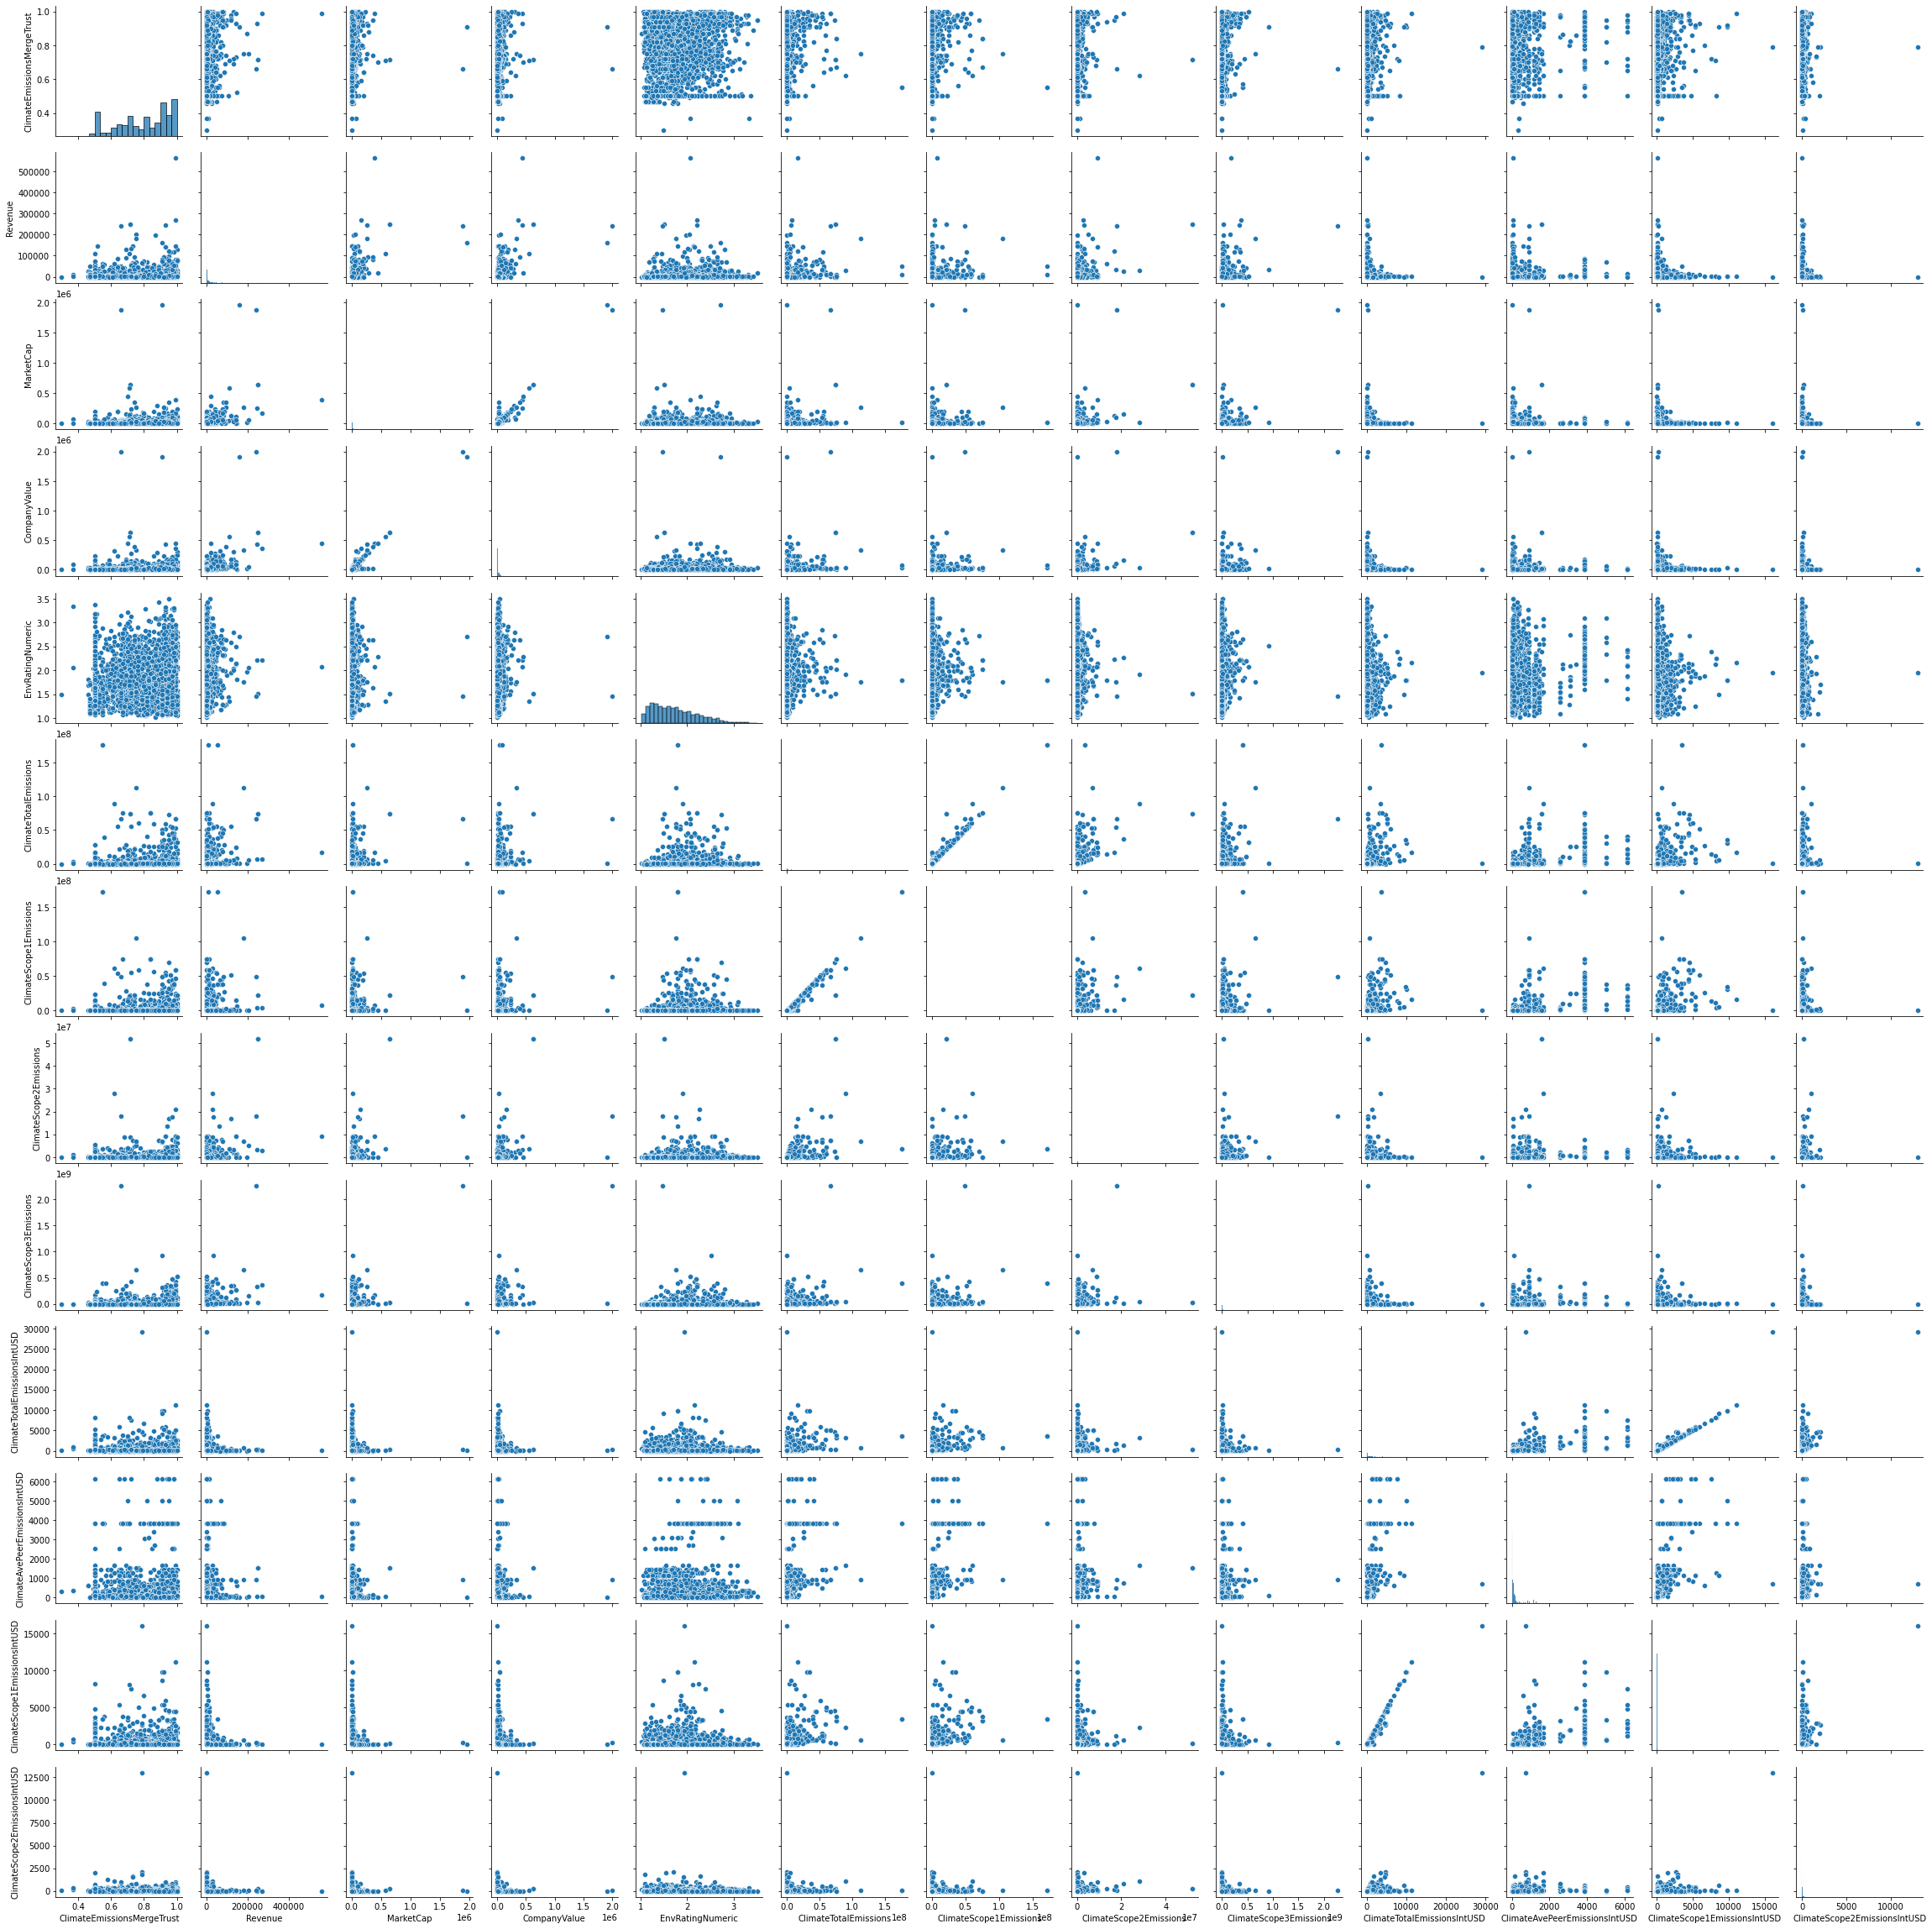

In [25]:
sns.pairplot(data)

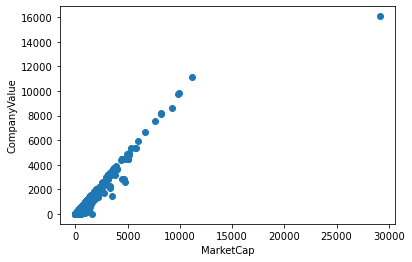

In [29]:
# Scatter plot
plt.scatter(data.ClimateTotalEmissionsIntUSD, data.ClimateScope1EmissionsIntUSD)
plt.xlabel("MarketCap")
plt.ylabel("CompanyValue")
plt.show()

### MarketCap and CompanyValue :
The univariate analysis highlights a linear relation between MarketCap and CompanyValue and also between ClimateScope1EmissionsIntUSD and ClimateTotalEmissionsIntUSD. Hence, we decided to drop one from each couple.

In [26]:
data.drop(['CompanyValue', 'ClimateTotalEmissionsIntUSD', 'ClimateTotalEmissions'], axis = 1 , inplace=True)
test.drop(['CompanyValue', 'ClimateTotalEmissionsIntUSD', 'ClimateTotalEmissions'], axis = 1 , inplace=True)

## Outliers

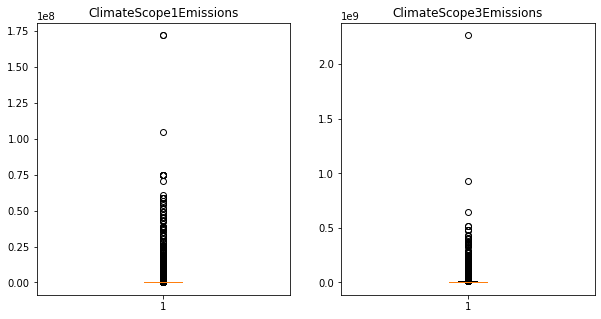

In [142]:
# Create a figure with two subplots in a single row
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# Plot the first figure in the left subplot
axs[0].boxplot(data['ClimateScope1Emissions'])
axs[0].set_title('ClimateScope1Emissions')

# Plot the second 
axs[1].boxplot(data['ClimateScope3Emissions'])
axs[1].set_title('ClimateScope3Emissions')

# Show the plot
plt.show()

The boxplots highlight the existence of outliers. We then decide to remove the most extreme values.

In [143]:
data = preprocessing.remove_outliers(data)

# MODELING : CATBOOST

## PARAMETERS 
To compute the best parameters for our model, we use the Gridsearchfunction of CatbBoost

- Iterations : 5000 appeared to be the best compromised to have a good score while avoiding overfitting

- Learning rate :  The default value of the learning rate offers good results

- Depth : 6 gives the best results

- One_hot_max_size : 1000 is a superior bound that permits to encode our categorical features 

- Loss_function: "MAE" as required by the challenge

- 'l2_leaf_reg': 1 Value of the best model

In [144]:
#params of the model
params = {
        'iterations': 5000,
        #'learning_rate': 0.03,
        'depth': 6,
        "loss_function": "MAE",
        'l2_leaf_reg': 1,
        'one_hot_max_size': 1000
        }

## EVALUATION OF THE MODEL

We use Cross Validation to validate the parameters we chose.

In [145]:
df = data.copy(deep=True)
#split of datas
X, y = processing.X_y_split(df)
# Categorical Features
str_columns = list(df.select_dtypes('object').columns)
final_pool = cb.Pool(
    data = X,
    label = y,
    cat_features = str_columns
)

In [147]:
scores = cb.cv(
    final_pool,
    params,
    fold_count=3,
    partition_random_seed=0,
    plot="False"
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
4:	learn: 1.5034861	test: 1.5079985	best: 1.5079985 (4)	total: 12ms	remaining: 12s
5:	learn: 1.4605916	test: 1.4655310	best: 1.4655310 (5)	total: 14.5ms	remaining: 12.1s
6:	learn: 1.4193725	test: 1.4243780	best: 1.4243780 (6)	total: 16.9ms	remaining: 12s
7:	learn: 1.3790316	test: 1.3841553	best: 1.3841553 (7)	total: 19.2ms	remaining: 12s
8:	learn: 1.3403313	test: 1.3451775	best: 1.3451775 (8)	total: 21.7ms	remaining: 12s
9:	learn: 1.3027311	test: 1.3076550	best: 1.3076550 (9)	total: 24.6ms	remaining: 12.3s
10:	learn: 1.2663068	test: 1.2712122	best: 1.2712122 (10)	total: 83.2ms	remaining: 37.8s
11:	learn: 1.2308453	test: 1.2360188	best: 1.2360188 (11)	total: 93.7ms	remaining: 39s
12:	learn: 1.1961880	test: 1.2015195	best: 1.2015195 (12)	total: 97.8ms	remaining: 37.5s
13:	learn: 1.1629841	test: 1.1683853	best: 1.1683853 (13)	total: 101ms	remaining: 36s
14:	learn: 1.1302853	test: 1.1357466	best: 1.1357466 (14)	t

In [152]:
print("The average MAE for our model is : " + str(scores.loc[scores['test-MAE-mean'].argmin(), 'test-MAE-mean']))

The average MAE for our model is : 0.23710451695007148


# Final Submission

In [151]:
# Fitting the model to the whole data set
model = cb.CatBoostRegressor(**params)
model.fit(final_pool)

0:	learn: 0.3784280	total: 2.5ms	remaining: 12.5s
1:	learn: 0.3745003	total: 6.74ms	remaining: 16.9s
2:	learn: 0.3708842	total: 9.18ms	remaining: 15.3s
3:	learn: 0.3673451	total: 11.5ms	remaining: 14.3s
4:	learn: 0.3637098	total: 13.8ms	remaining: 13.8s
5:	learn: 0.3602808	total: 16.1ms	remaining: 13.4s
6:	learn: 0.3570352	total: 18.4ms	remaining: 13.1s
7:	learn: 0.3540900	total: 20.8ms	remaining: 12.9s
8:	learn: 0.3509191	total: 23.1ms	remaining: 12.8s
9:	learn: 0.3484310	total: 25.3ms	remaining: 12.6s
10:	learn: 0.3458226	total: 27.6ms	remaining: 12.5s
11:	learn: 0.3430511	total: 30.2ms	remaining: 12.5s
12:	learn: 0.3401578	total: 32.5ms	remaining: 12.5s
13:	learn: 0.3377766	total: 34.9ms	remaining: 12.4s
14:	learn: 0.3355130	total: 37.1ms	remaining: 12.3s
15:	learn: 0.3332410	total: 39.4ms	remaining: 12.3s
16:	learn: 0.3306789	total: 41.8ms	remaining: 12.3s
17:	learn: 0.3280504	total: 44.1ms	remaining: 12.2s
18:	learn: 0.3257231	total: 46.4ms	remaining: 12.2s
19:	learn: 0.3235250	to

In [153]:
# Exporting the final predictions using the function export_pred defined in processing.py 
export_pred(model, test, 'team07_final')

# Analysis of the model

Text(0.5, 0, 'CatBoost Feature Importance')

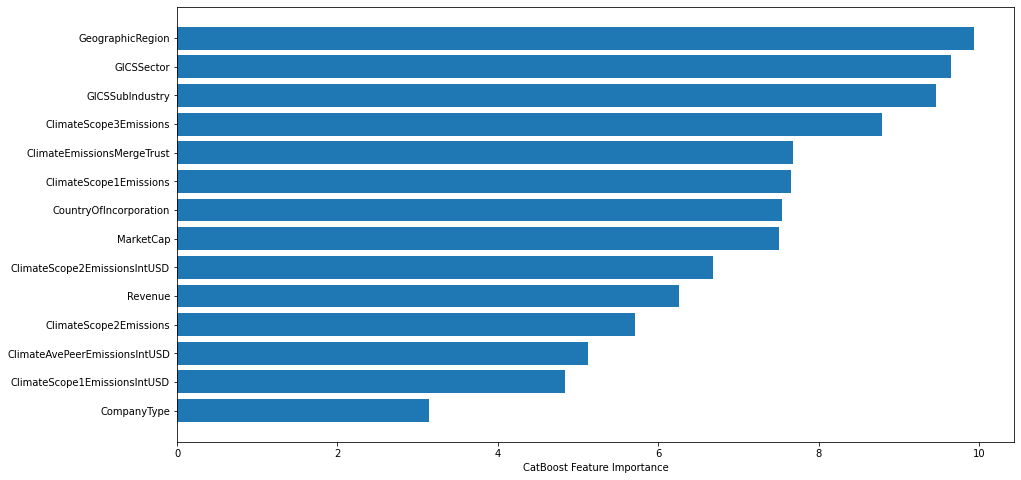

In [157]:
plt.figure(figsize = (15,8))
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(X.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance])
        
plt.xlabel("CatBoost Feature Importance")

This plot shows that each feature contributes significantly to the predictions.  

In [96]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 31.6 MB/s eta 0:00:00


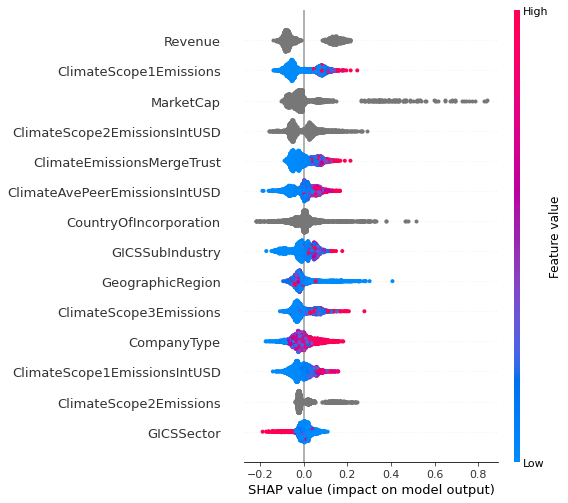

In [159]:
plt.figure(figsize=(15,10))
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test)
shap.summary_plot(shap_values, test, feature_names = test.columns[sorted_feature_importance])